In [1]:
# %load defaults.ipy
# %load defaults.ipy
import sys
for p in sys.path:
    if 'netcdf' in p.lower():
        sys.path.remove(p)
    if 'matplotlib' in p.lower():
        sys.path.remove(p)
from numpy import *
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 200
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import PIL



def writeMetadata(filename, data):
    im = PIL.Image.open(filename)
    
    meta = PIL.PngImagePlugin.PngInfo()

    for key in data.keys():
        meta.add_text(key, data[key])
    im.save(filename, "png", pnginfo=meta)
    
def showAndSave(name):
    fig = plt.gcf()
    ax = plt.gca()
    ax.text(0.95, 0.01, 'By Kjetil Olsen Lye\nkjetil.o.lye@gmail.com',
         fontsize=3, color='gray',
         ha='right', va='bottom', alpha=0.5, transform=ax.transAxes)

    matplotlib2tikz.save(name + '.tikz',
           figureheight = '\\figureheight',
           figurewidth = '\\figurewidth')
    
    savenamepng = name + '.png'
    plt.savefig(savenamepng)
    
    writeMetadata(savenamepng, {'Copyright' : 'Copyright, Kjetil Olsen Lye kjetil.o.lye@gmail.com'
                               })
    plt.show()
    
def legendLeft():
    ax = plt.gca()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [2]:
import sys
sys.path.append("/cluster/home/klye/alsvinn/build/python/")
sys.path.append("/home/kjetil/projects/alsvinn/build/python/")
import alsvinn

In [3]:
import re
def computeConvergence(basename, showSingle=False):
    if 'sine_' in basename:
        name = re.search(r'sine_(.+)\/', basename).group(1)
    else:
        name = re.search(r'brownian_(.+)\/', basename).group(1)
    print(basename)
    name = name.replace("_", " ").title()
    
    N = 128
    display(HTML("<h1>%s</h1>" % name))
    
    Ms = 2**array(range(3,13))
    
    for t in [0,1]:
        plt.figure(t)
        errors = []
        for M in Ms:
            try:
                r = alsvinn.run(name='test', base_xml=basename, dimension=[N,1,1], uq=True, samples=M)
            except Exception as e:
                print("%s failed, see error message below: " % name)
                print (e)
                return
            mean = r.get_data('u', timestep=t, statistics='mean')
            
            
            if M > Ms[0]:
                errors.append(sqrt(sum(abs(mean-meanPrev)**2)/mean.shape[0]))
            meanPrev = mean
            if showSingle:
                x = linspace(0,1,N)
                plt.plot(x,mean)
                plt.ylabel('$\mathbb{E}(u(x,%d))$' % t)
                plt.xlabel('$x$')
                plt.title('$M=%d$' % M)
                plt.show()
        p = plt.loglog(Ms[:-1], errors, '-o',label=name)
        poly = polyfit(log(Ms[:-1]), log(errors), 1)
        
        plt.loglog(Ms[:-1], exp(poly[1])*Ms[:-1]**poly[0], '--', label='$O(M^{%.3f})$' % poly[0], color=p[0].get_color())
        plt.xlabel("M")
        plt.ylabel("Error")
        
        if not showSingle:
            plt.title("Cauchy convergence at $T=%d$ (normalized time)" % t)
        legendLeft()
        if showSingle:
            
            plt.title("Cauchy Convergence for %s at $T=%d$ (normalized time)" % (name,t))
            plt.show()
    
    for t in [0,1]:
        try:
            r = alsvinn.run(name='test', base_xml=basename, dimension=[N,1,1], uq=True, samples=Ms[-1])
        except Exception as e:
            print("%s failed, see error message below: " % name)
            print (e)
            return
        errors = []
        plt.figure(2+t)
       
        
        referenceSolution = r.get_data('u', timestep=t, statistics='mean')
        
        for M in Ms[:-1]:
            try:
                r = alsvinn.run(name='test', base_xml=basename, dimension=[N,1,1], uq=True, samples=M)
            except Exception as e:
                print("%s failed, see error message below: " % name)
                print (e)
                return
            mean = r.get_data('u', timestep=t, statistics='mean')
               
            
            
            errors.append(sqrt(sum(abs(mean-referenceSolution)**2)/mean.shape[0]))
           
        p = plt.loglog(Ms[:-1], errors, '-o',label=name)
        poly = polyfit(log(Ms[:-1]), log(errors), 1)
        
        plt.loglog(Ms[:-1], exp(poly[1])*Ms[:-1]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0])
        plt.xlabel("M")
        plt.ylabel("Error")
        if not showSingle:
            plt.title("Convergence against reference solution\n$T=%d$ (normalized time)" % t)
        
        legendLeft()
        if showSingle:
            plt.title("Convergence for %s at $T=%d$ (normalized time)\nagainst reference solution" % (name,t))
            plt.show()
    

# Smooth initial data

Here we test with some smooth initial data of the form

$$ u_0(\omega,x)=\sum_{n=1}^{10} a_n(x)X_n(\omega)$$

approximating a Gaussian field. Here we have ten dimensions.

In [4]:
import glob

for basename in glob.glob("../configs/sine_*"):
    computeConvergence(basename + "/sine.xml")

../configs/sine_faure/sine.xml


Faure failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_open(mpiCommunicator, filename.c_str(), NC_WRITE| NC_64BIT_DATA, mpiInfo, &file)

Error code: -220

Error message: Unknown Error
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:53

In function: virtual void alsfvm::io::NetCDFMPIWriter::write(const alsfvm::volume::Volume&, const alsfvm::volume::Volume&, const alsfvm::grid::Grid&, const alsfvm::simulator::TimestepInformation&)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_halton/sine.xml


Halton failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_open(mpiCommunicator, filename.c_str(), NC_WRITE| NC_64BIT_DATA, mpiInfo, &file)

Error code: -51

Error message: NetCDF: Unknown file format
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:53

In function: virtual void alsfvm::io::NetCDFMPIWriter::write(const alsfvm::volume::Volume&, const alsfvm::volume::Volume&, const alsfvm::grid::Grid&, const alsfvm::simulator::TimestepInformation&)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_latin_center/sine.xml


Latin Center failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_open(mpiCommunicator, filename.c_str(), NC_WRITE| NC_64BIT_DATA, mpiInfo, &file)

Error code: -220

Error message: Unknown Error
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:53

In function: virtual void alsfvm::io::NetCDFMPIWriter::write(const alsfvm::volume::Volume&, const alsfvm::volume::Volume&, const alsfvm::grid::Grid&, const alsfvm::simulator::TimestepInformation&)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_latin_random/sine.xml


Latin Random failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_def_var(baseGroup, memoryName.c_str(), NC_DOUBLE, 3, dimensions.data(), &dataset)

Error code: -42

Error message: NetCDF: String match to name in use
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:117

In function: virtual std::vector<int, std::allocator<int> > alsfvm::io::NetCDFMPIWriter::makeDataset(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, std::array<int, 3ul>)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_monte_carlo/sine.xml


Monte Carlo failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
MPI error (MPI_File_write_at) : MPI_ERR_IO: input/output error
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_enddef(file)

Error code: -206

Error message: Unknown Error
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:144

In function: virtual void alsfvm::io::NetCDFMPIWriter::writeToFile(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, const alsfvm::volume::Volume&, const alsfvm::grid::Grid&, const alsfvm::simulator::TimestepInformation&, bool)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_niederreiter2/sine.xml


Niederreiter2 failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
boost::dll::shared_library::load() failed (dlerror system message: ./libGENERATOR.so: cannot open shared object file: No such file or directory): Bad file descriptor
'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_sobol/sine.xml


Sobol failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_def_var(baseGroup, memoryName.c_str(), NC_DOUBLE, 3, dimensions.data(), &dataset)

Error code: -42

Error message: NetCDF: String match to name in use
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:117

In function: virtual std::vector<int, std::allocator<int> > alsfvm::io::NetCDFMPIWriter::makeDataset(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, std::array<int, 3ul>)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_hammersley/sine.xml


Hammersley failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_def_var(baseGroup, memoryName.c_str(), NC_DOUBLE, 3, dimensions.data(), &dataset)

Error code: -42

Error message: NetCDF: String match to name in use
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:117

In function: virtual std::vector<int, std::allocator<int> > alsfvm::io::NetCDFMPIWriter::makeDataset(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, std::array<int, 3ul>)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'


../configs/sine_faure/sine.xml


Faure failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_open(mpiCommunicator, filename.c_str(), NC_WRITE| NC_64BIT_DATA, mpiInfo, &file)

Error code: -220

Error message: Unknown Error
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:53

In function: virtual void alsfvm::io::NetCDFMPIWriter::write(const alsfvm::volume::Volume&, const alsfvm::volume::Volume&, const alsfvm::grid::Grid&, const alsfvm::simulator::TimestepInformation&)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_halton/sine.xml


Halton failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_def_var(baseGroup, memoryName.c_str(), NC_DOUBLE, 3, dimensions.data(), &dataset)

Error code: -42

Error message: NetCDF: String match to name in use
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:117

In function: virtual std::vector<int, std::allocator<int> > alsfvm::io::NetCDFMPIWriter::makeDataset(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, std::array<int, 3ul>)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_latin_center/sine.xml


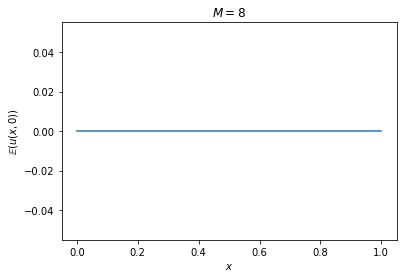

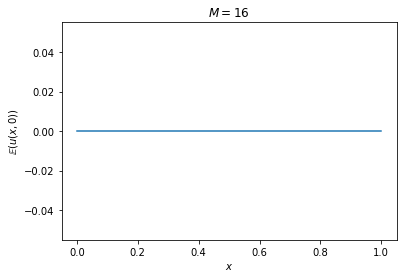

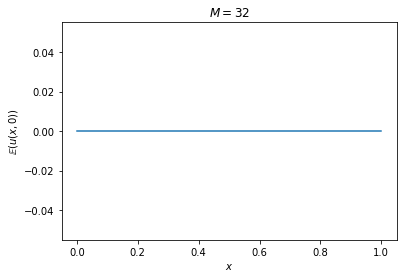

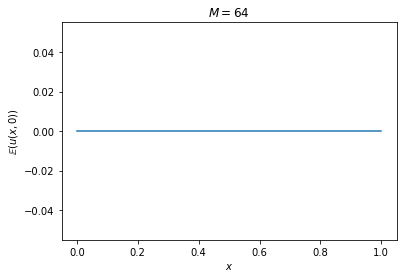

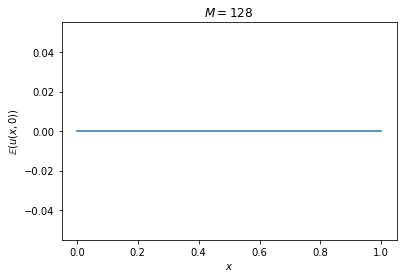

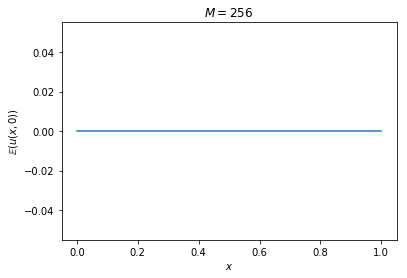

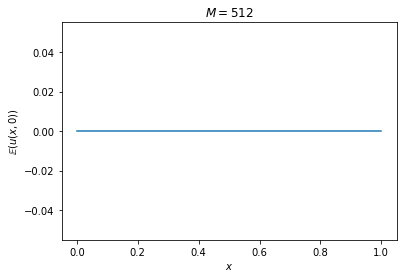

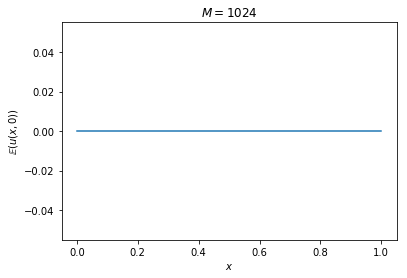

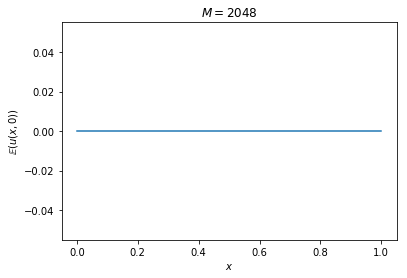

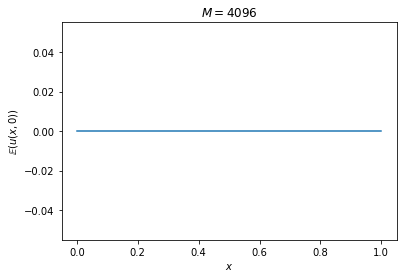

/cluster/home/klye/.local/lib64/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/cluster/home/klye/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/cluster/home/klye/.local/lib64/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


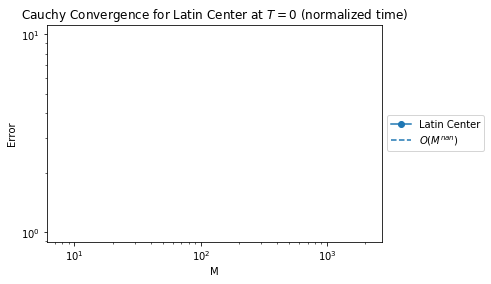

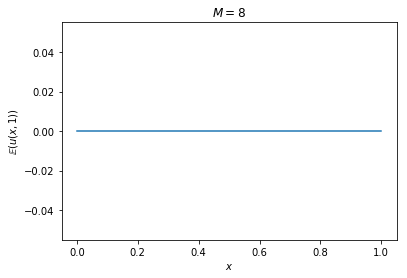

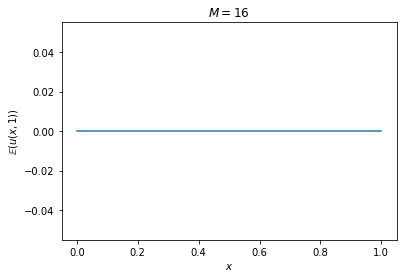

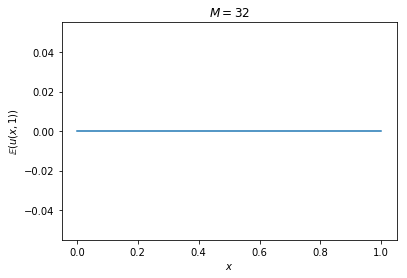

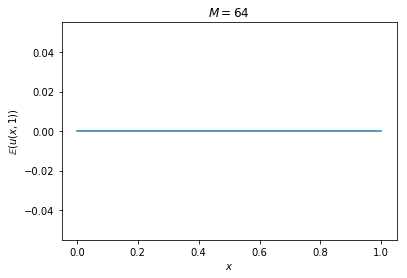

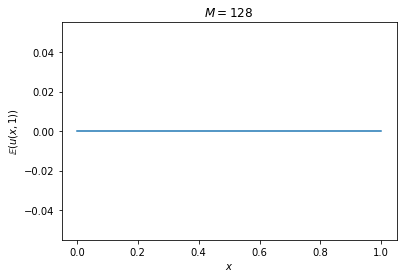

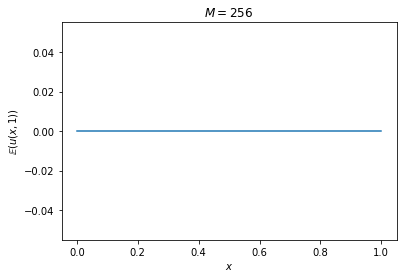

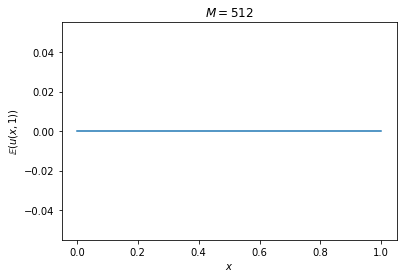

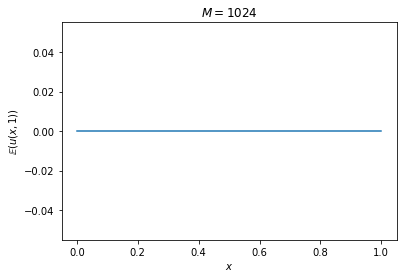

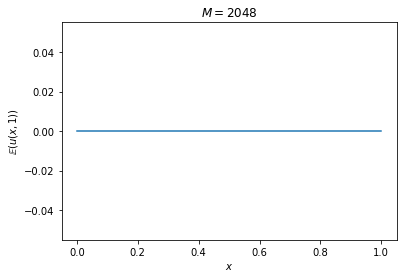

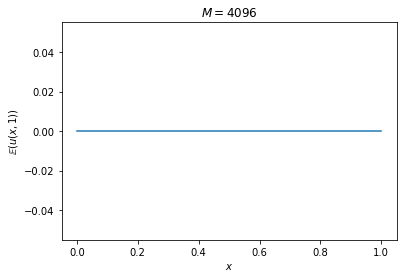

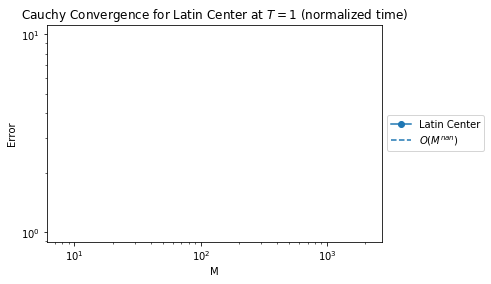

/cluster/home/klye/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log


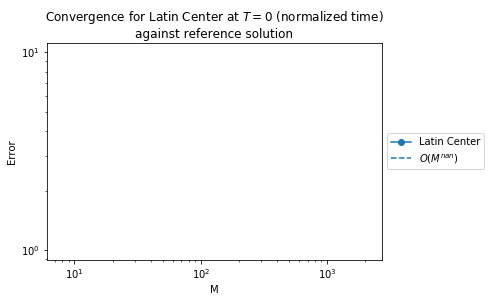

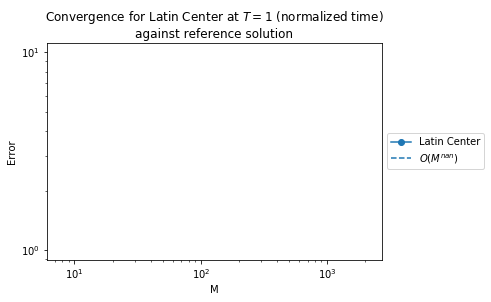

../configs/sine_latin_random/sine.xml


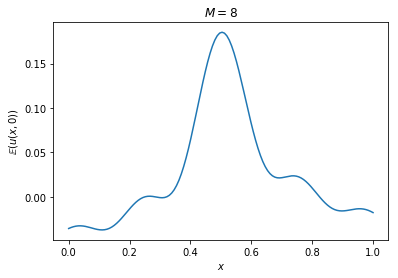

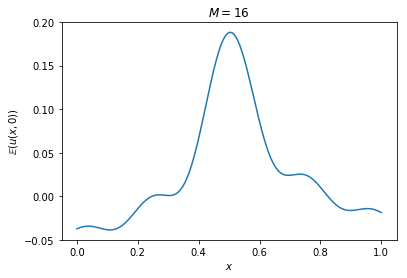

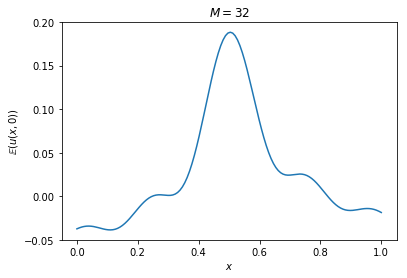

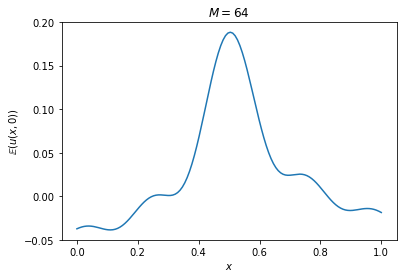

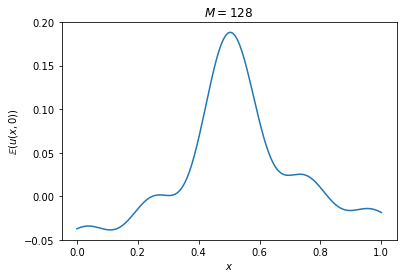

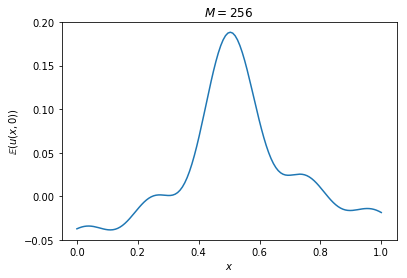

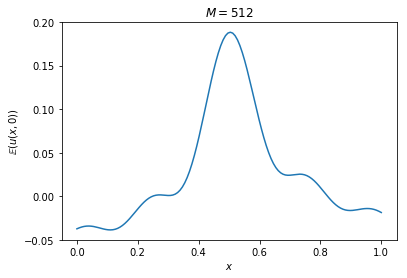

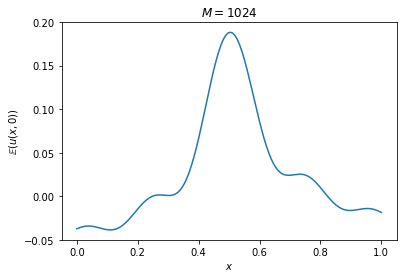

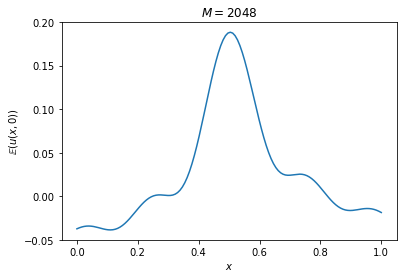

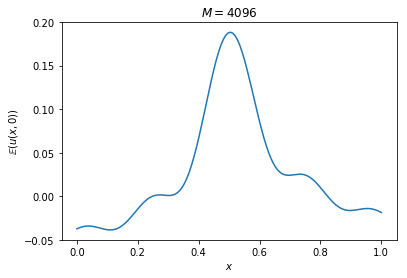

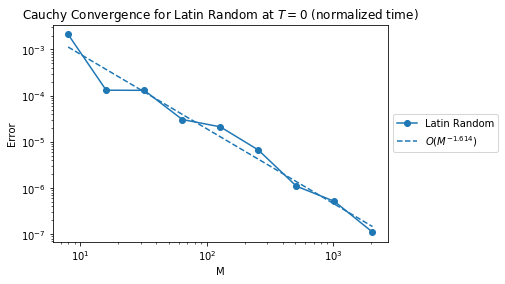

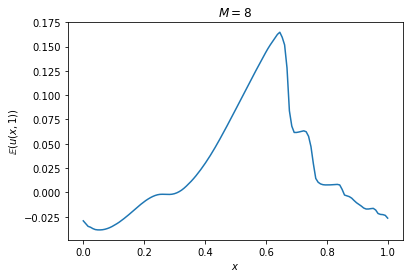

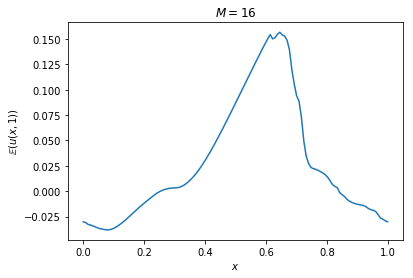

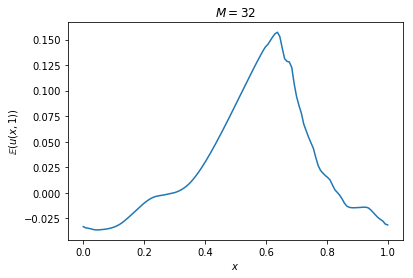

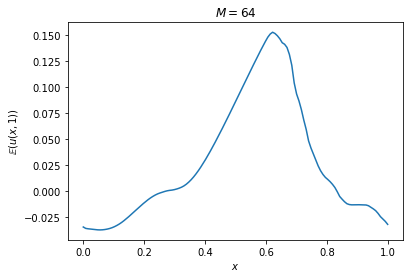

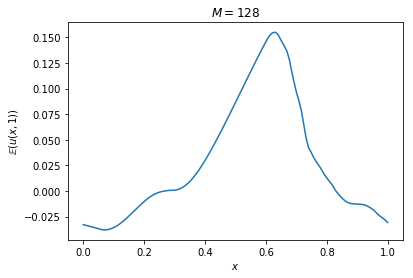

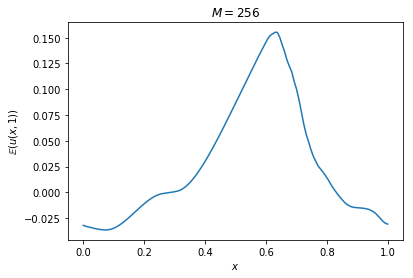

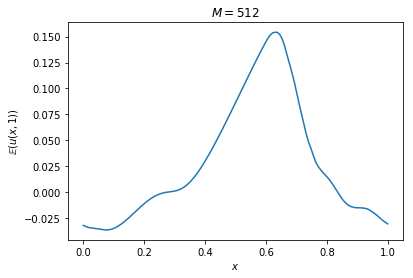

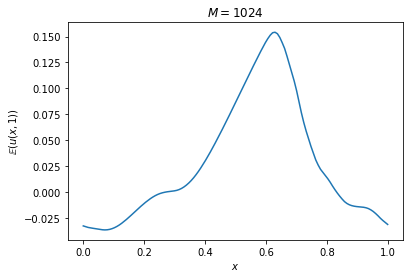

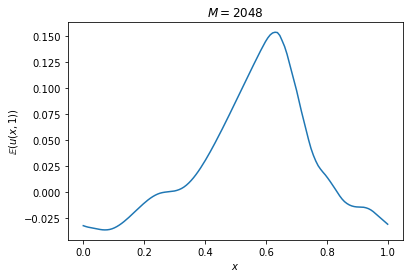

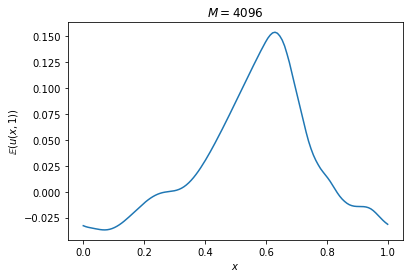

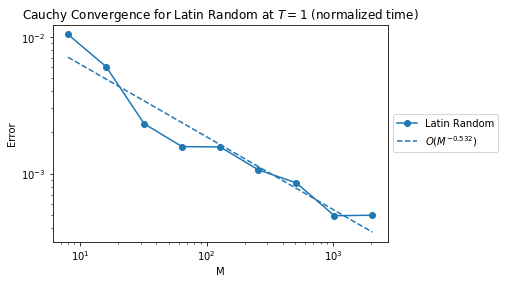

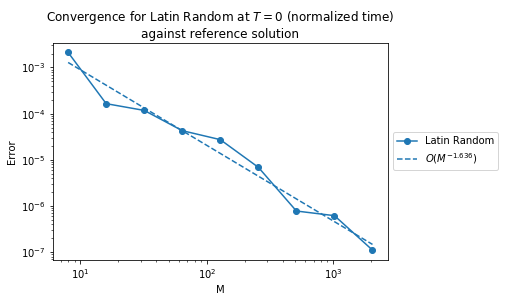

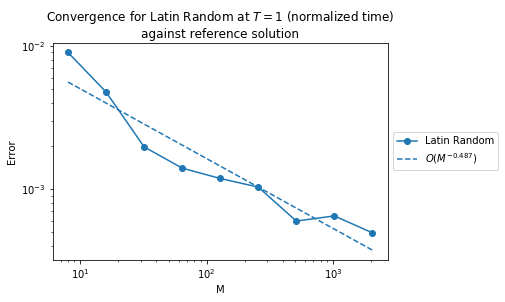

../configs/sine_monte_carlo/sine.xml


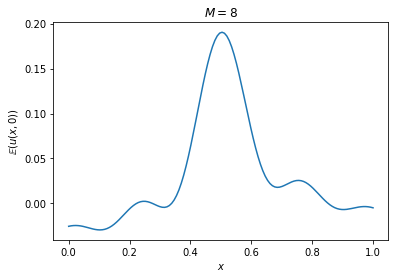

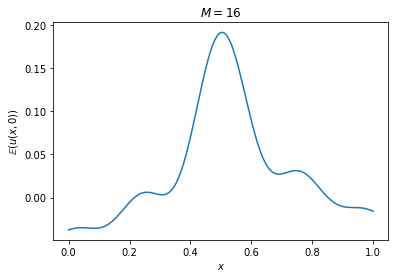

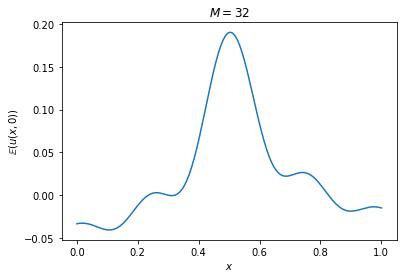

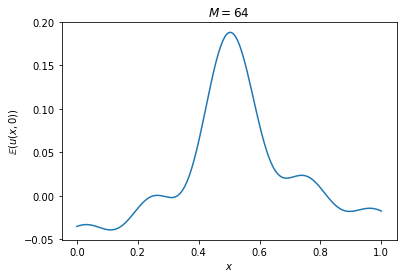

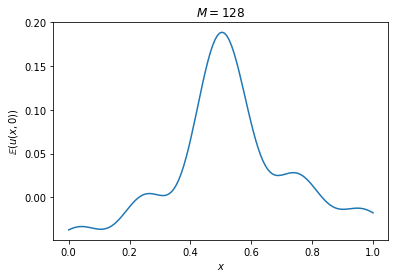

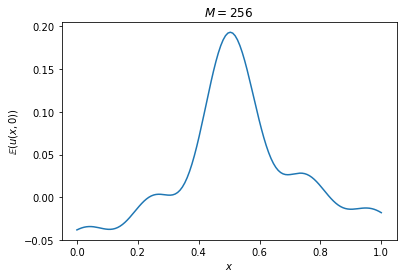

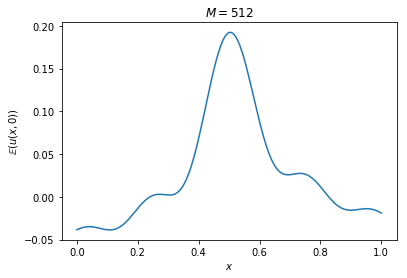

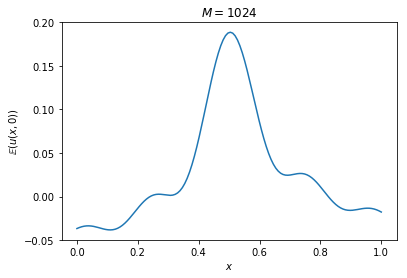

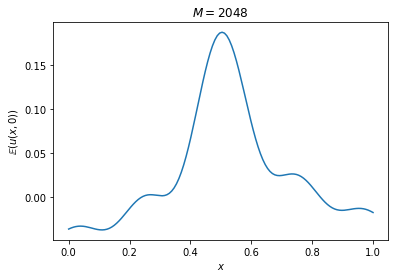

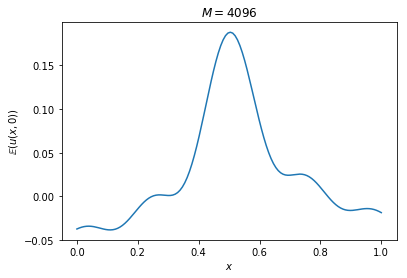

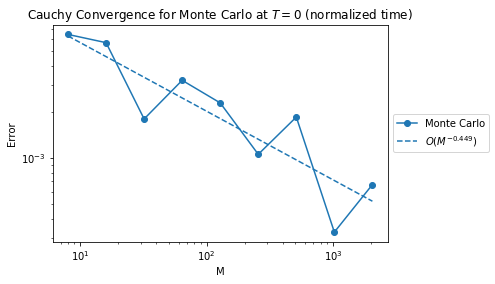

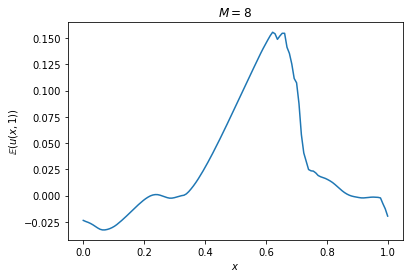

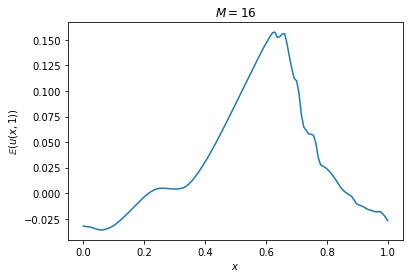

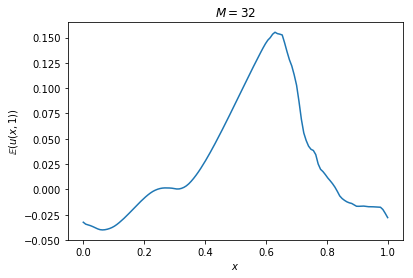

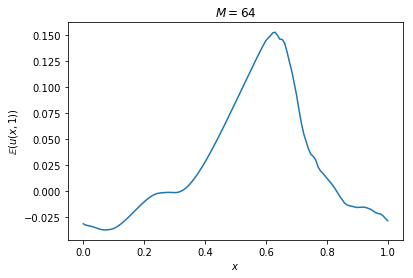

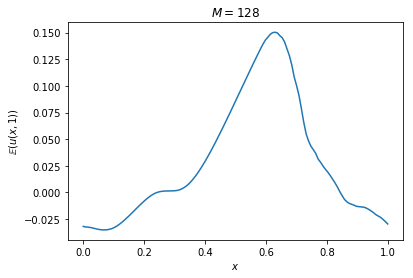

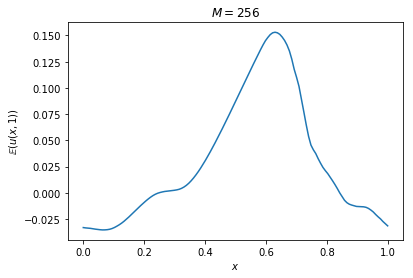

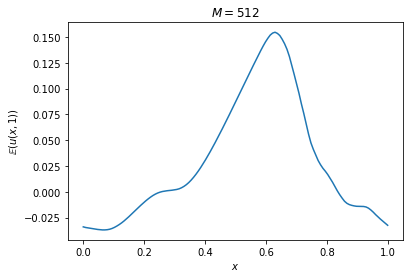

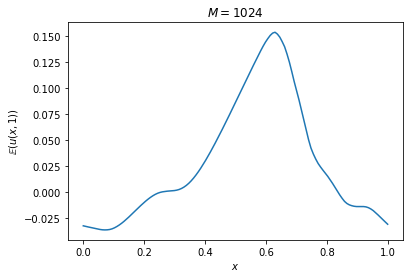

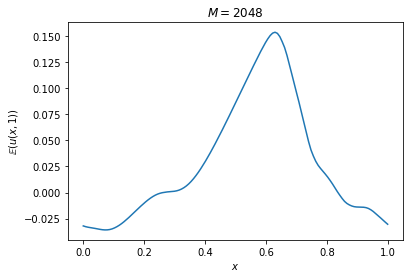

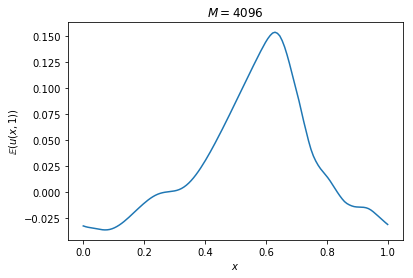

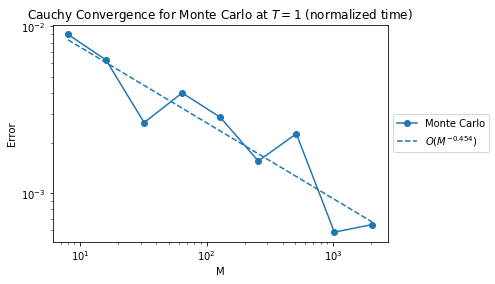

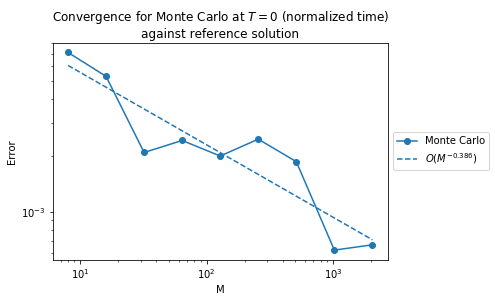

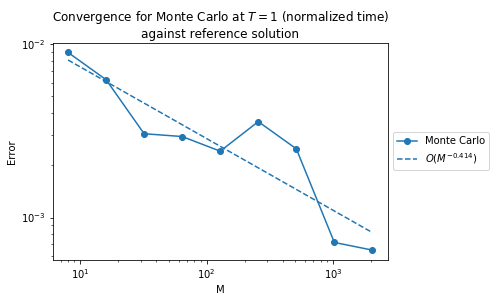

../configs/sine_niederreiter2/sine.xml


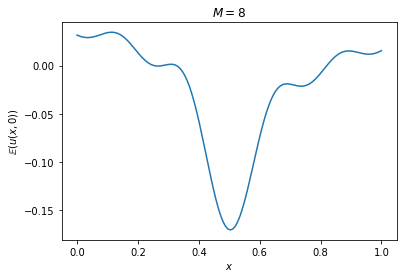

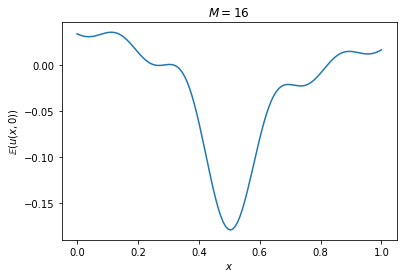

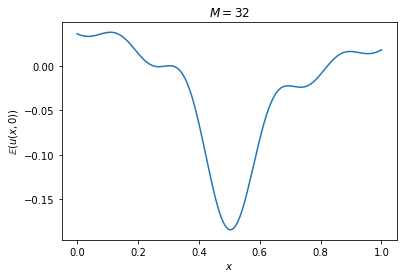

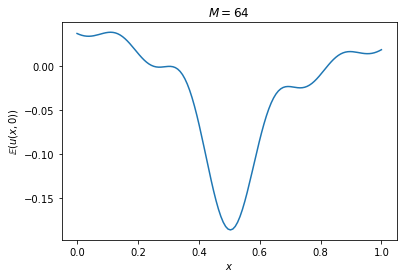

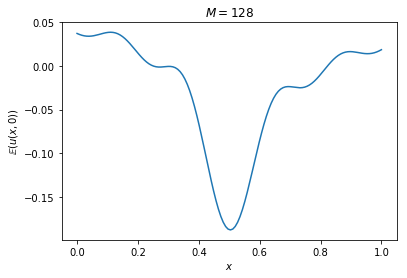

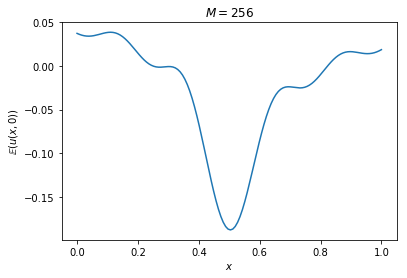

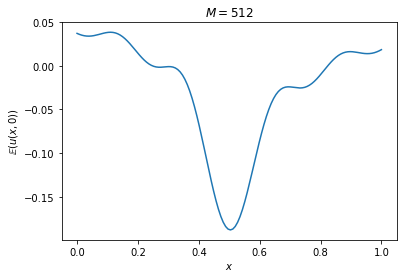

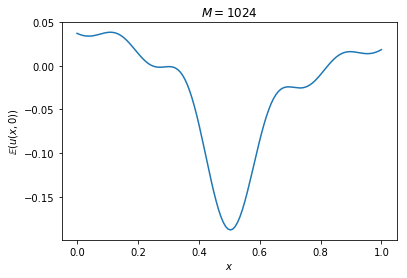

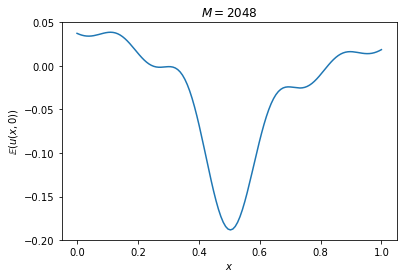

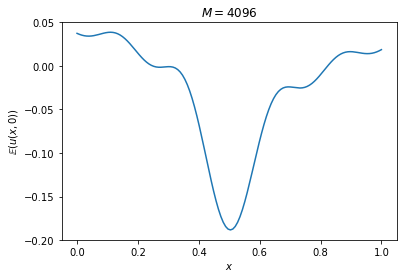

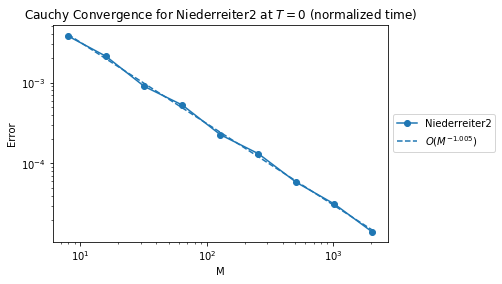

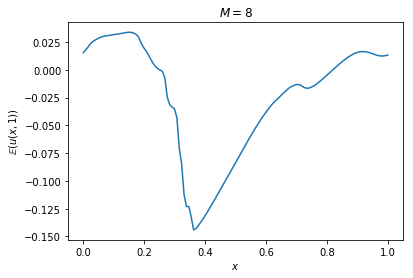

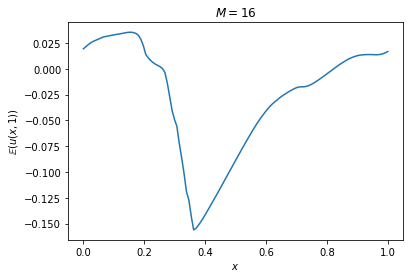

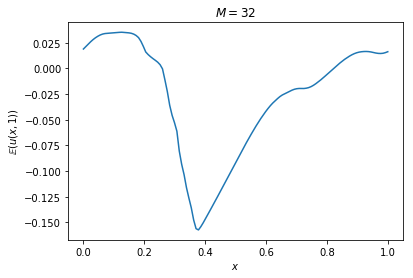

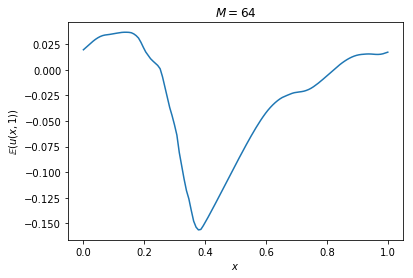

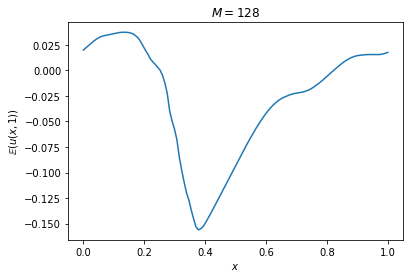

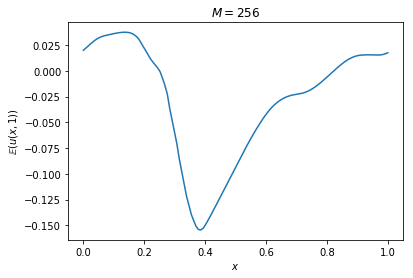

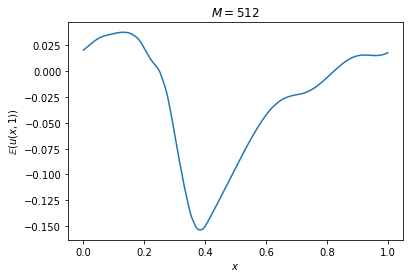

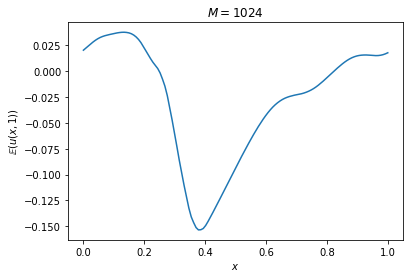

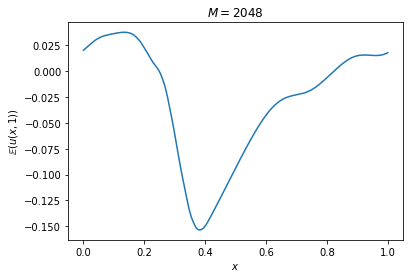

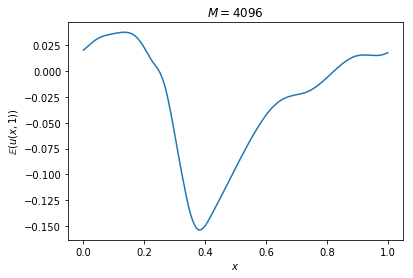

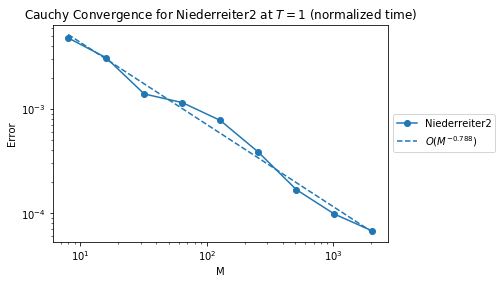

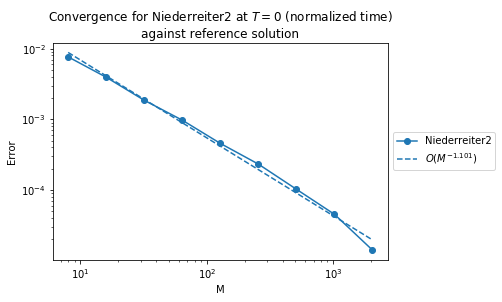

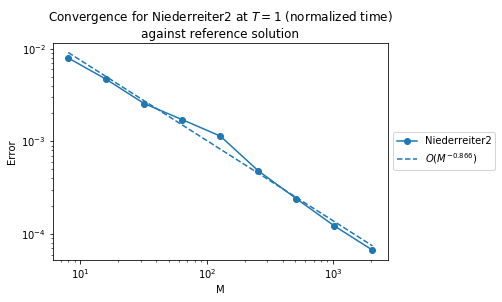

../configs/sine_sobol/sine.xml


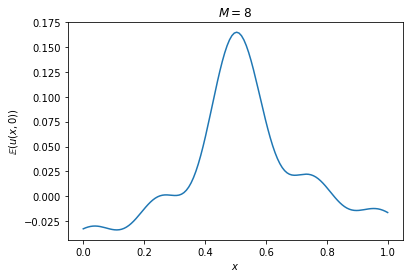

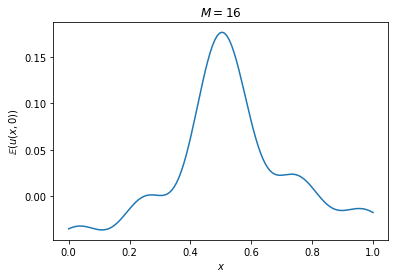

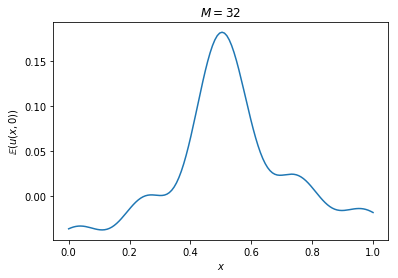

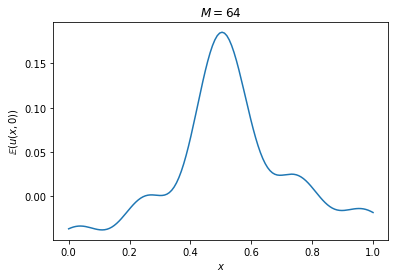

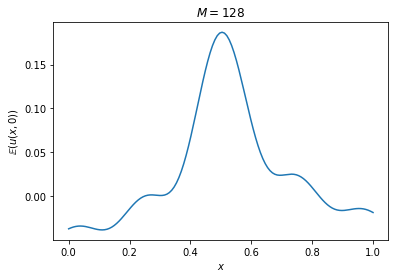

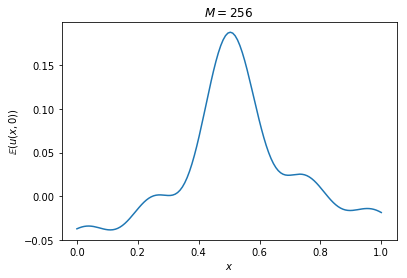

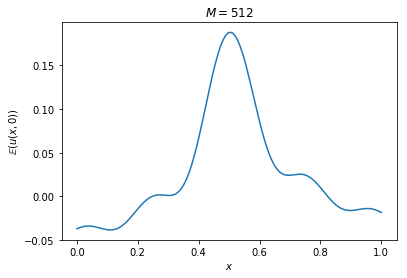

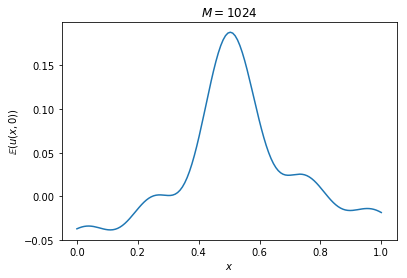

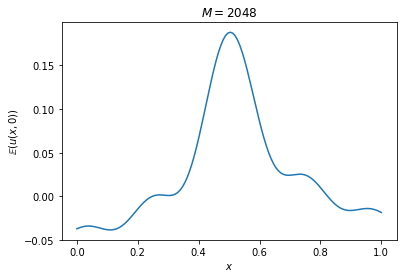

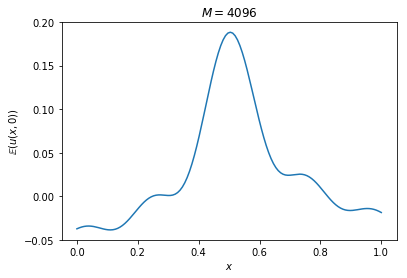

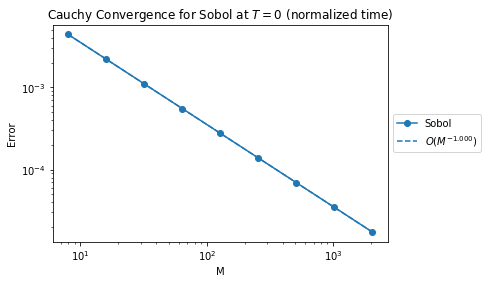

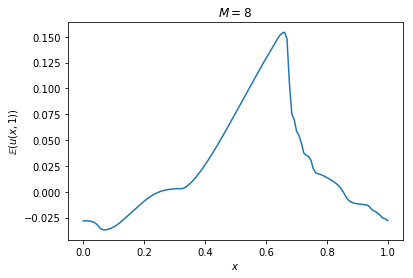

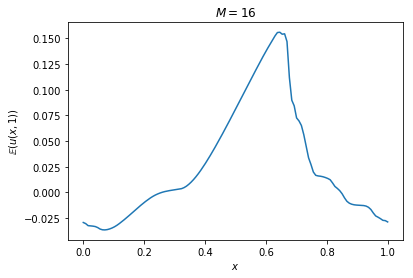

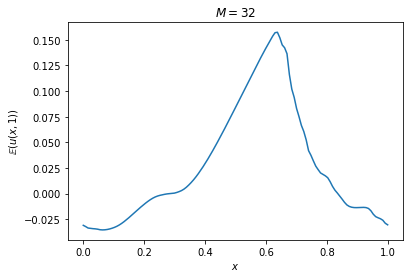

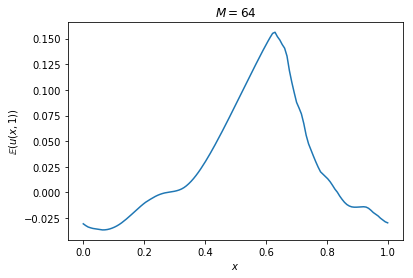

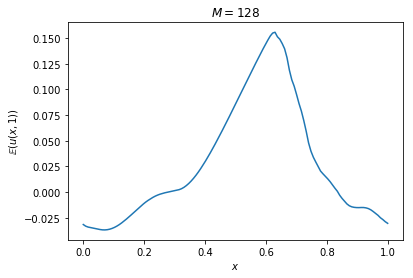

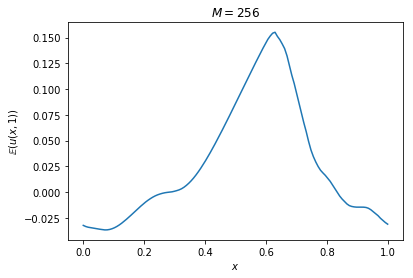

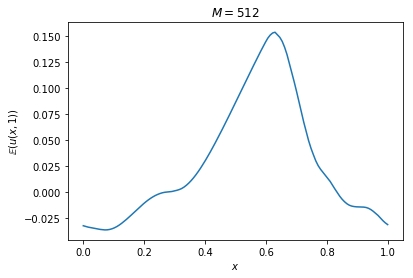

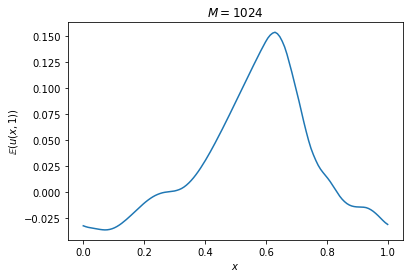

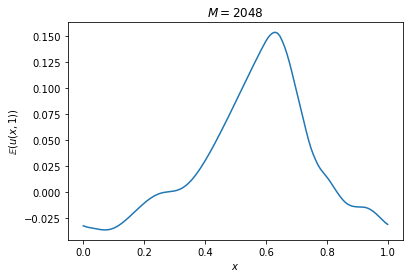

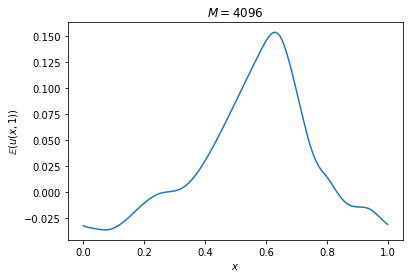

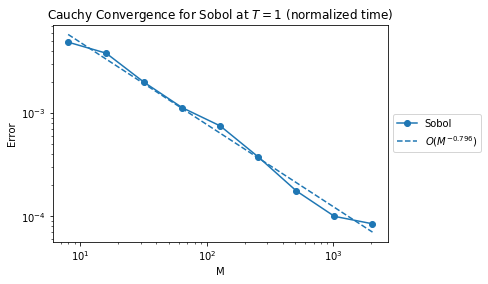

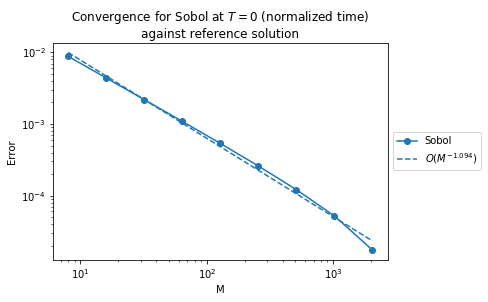

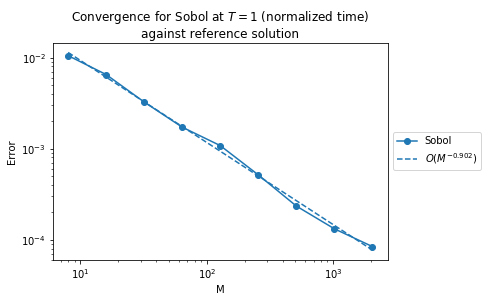

../configs/sine_hammersley/sine.xml


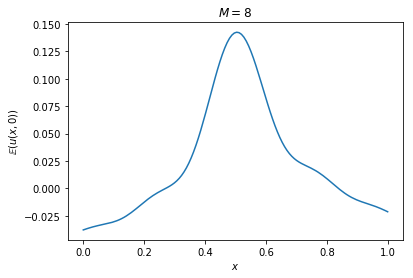

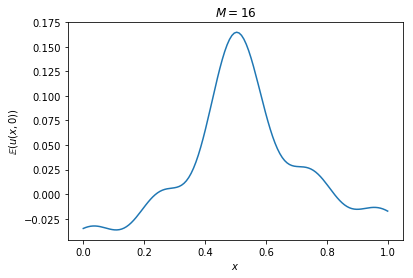

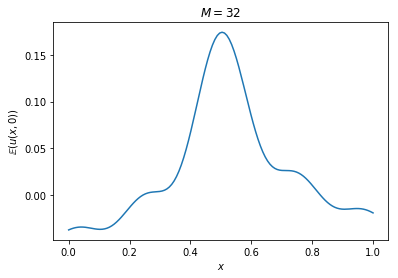

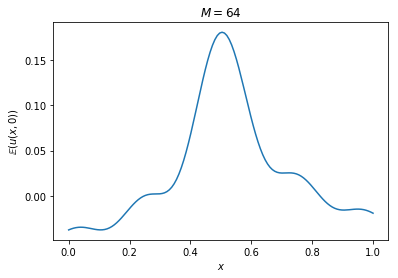

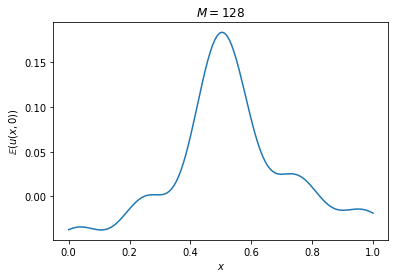

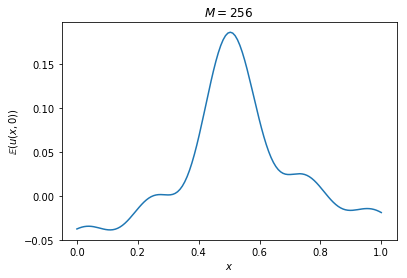

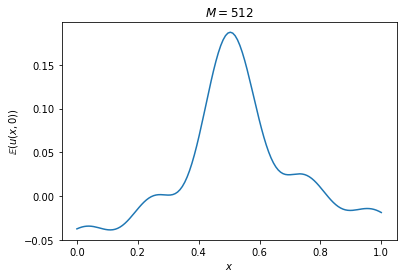

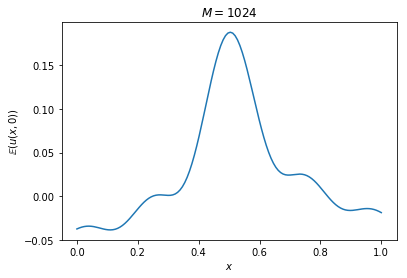

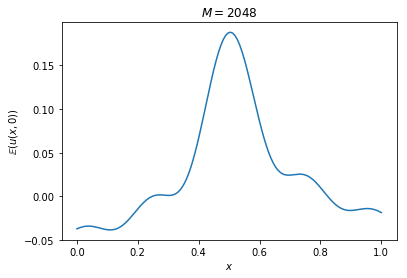

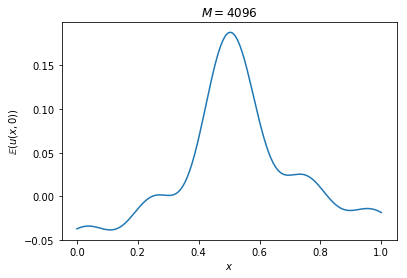

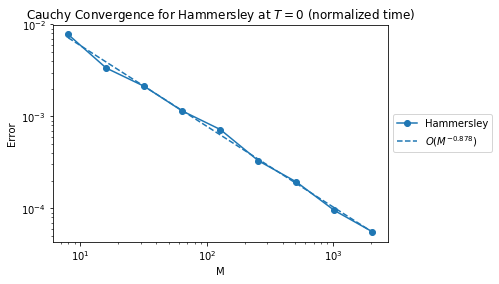

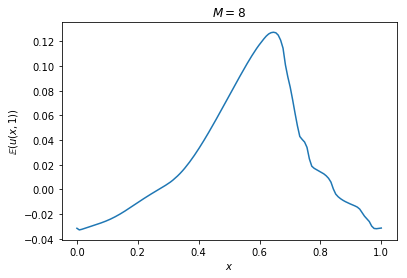

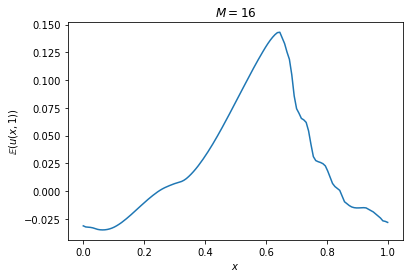

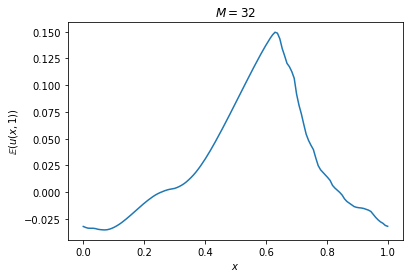

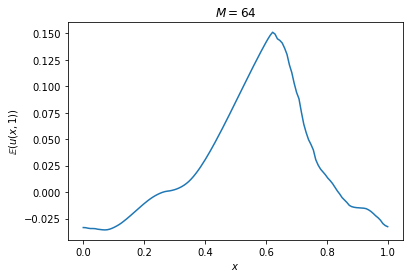

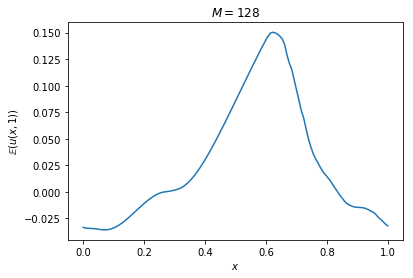

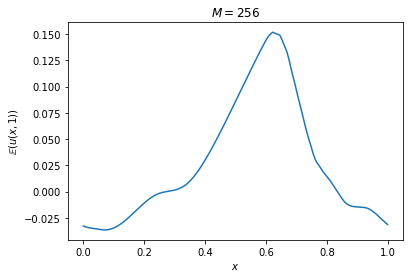

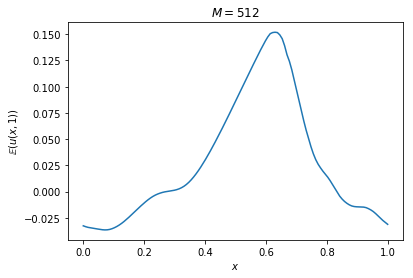

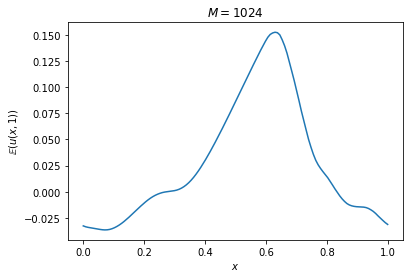

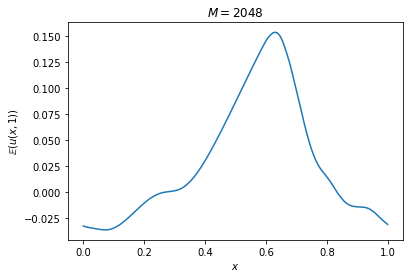

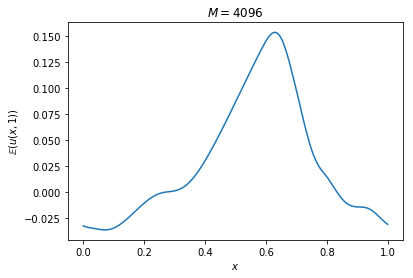

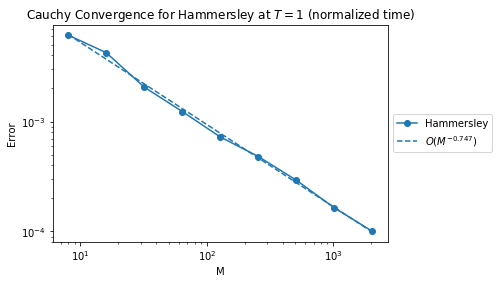

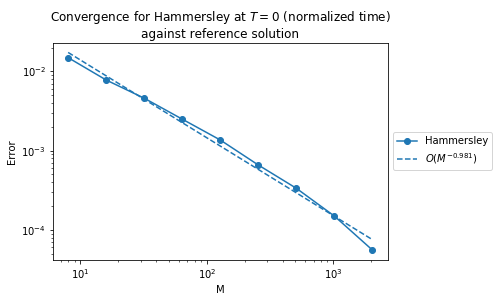

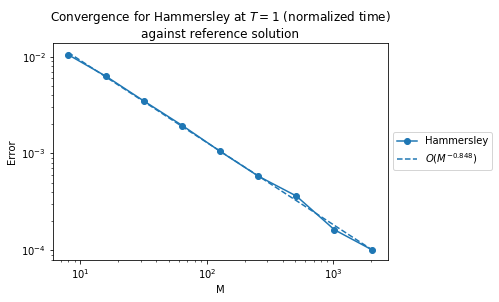

In [5]:
import glob

for basename in glob.glob("../configs/sine_*"):
    computeConvergence(basename + "/sine.xml", True)

# Brownian initial data

Here we let the initial data be given as (truncated) Brownian motion, and we set
$$u_0(\omega, x) = B_x(\omega)$$
In the approximation, we use $1024$ dimensions. Not all QMC rules are able to handle this dimension, they are skipped.

../configs/brownian_faure/brownian.xml


../configs/brownian_halton/brownian.xml


Halton failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
Size mismatch: 
\tthis->getSize() = 130
\tother.getSize() = 132
At /cluster/home/klye/alsvinn/alsfvm/src/memory/HostMemory.cpp:259

In function: void alsfvm::memory::HostMemory<T>::addPower(const alsfvm::memory::Memory<T>&, double) [with T = double]

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/brownian_latin_center/brownian.xml


Latin Center failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_def_var(baseGroup, memoryName.c_str(), NC_DOUBLE, 3, dimensions.data(), &dataset)

Error code: -42

Error message: NetCDF: String match to name in use
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:117

In function: virtual std::vector<int, std::allocator<int> > alsfvm::io::NetCDFMPIWriter::makeDataset(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, std::array<int, 3ul>)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/brownian_latin_random/brownian.xml


Latin Random failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b"terminate called after throwing an instance of 'boost::python::error_already_set'
[eu-c7-059-14:28727] *** Process received signal ***
[eu-c7-059-14:28727] Signal: Aborted (6)
[eu-c7-059-14:28727] Signal code:  (-6)
[eu-c7-059-14:28727] [ 0] /lib64/libpthread.so.0(+0xf5e0) [0x2b42594265e0]
[eu-c7-059-14:28727] [ 1] /lib64/libc.so.6(gsignal+0x37) [0x2b42614051f7]
[eu-c7-059-14:28727] [ 2] /lib64/libc.so.6(abort+0x148) [0x2b42614068e8]
[eu-c7-059-14:28727] [ 3] /cluster/apps/gcc/5.2.0/lib64/libstdc++.so.6(_ZN9__gnu_cxx27__verbose_terminate_handlerEv+0x15d) [0x2b4260eb9bad]
[eu-c7-059-14:28727] [ 4] /cluster/apps/gcc/5.2.0/lib64/libstdc++.so.6(+0x8cbc6) [0x2b4260eb7bc6]
[eu-c7-059-14:28727] [ 5] /cluster/apps/gcc/5.2.

Niederreiter2 failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_def_var(baseGroup, memoryName.c_str(), NC_DOUBLE, 3, dimensions.data(), &dataset)

Error code: -42

Error message: NetCDF: String match to name in use
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:117

In function: virtual std::vector<int, std::allocator<int> > alsfvm::io::NetCDFMPIWriter::makeDataset(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, std::array<int, 3ul>)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/brownian_sobol/brownian.xml


Sobol failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_def_var(baseGroup, memoryName.c_str(), NC_DOUBLE, 3, dimensions.data(), &dataset)

Error code: -42

Error message: NetCDF: String match to name in use
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:117

In function: virtual std::vector<int, std::allocator<int> > alsfvm::io::NetCDFMPIWriter::makeDataset(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, std::array<int, 3ul>)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/brownian_template/brownian.xml


Template failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
boost::dll::shared_library::load() failed (dlerror system message: ./libGENERATOR.so: cannot open shared object file: No such file or directory): Bad file descriptor
'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'


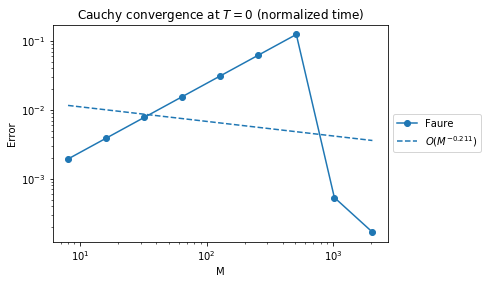

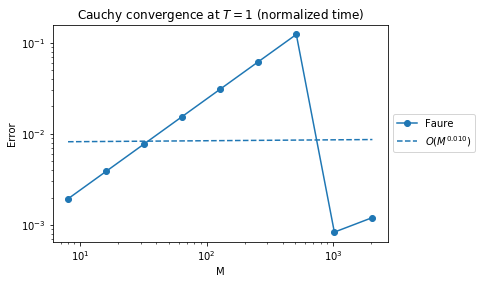

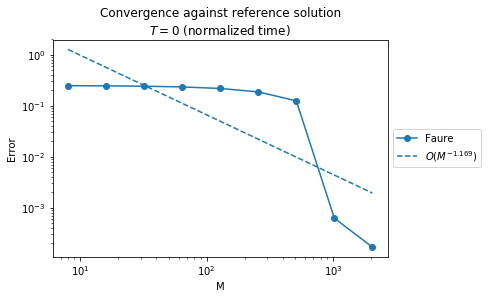

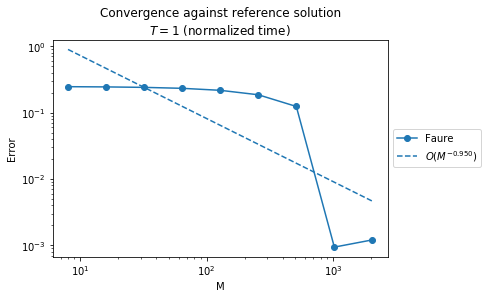

In [6]:
import glob

for basename in glob.glob("../configs/brownian_*"):
    computeConvergence(basename + "/brownian.xml")

In [7]:
import glob

for basename in glob.glob("../configs/brownian_*"):
    computeConvergence(basename + "/brownian.xml", True)

../configs/brownian_faure/brownian.xml


Faure failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_def_var(baseGroup, memoryName.c_str(), NC_DOUBLE, 3, dimensions.data(), &dataset)

Error code: -42

Error message: NetCDF: String match to name in use
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:117

In function: virtual std::vector<int, std::allocator<int> > alsfvm::io::NetCDFMPIWriter::makeDataset(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, std::array<int, 3ul>)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/brownian_halton/brownian.xml


Halton failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_def_var(baseGroup, memoryName.c_str(), NC_DOUBLE, 3, dimensions.data(), &dataset)

Error code: -42

Error message: NetCDF: String match to name in use
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:117

In function: virtual std::vector<int, std::allocator<int> > alsfvm::io::NetCDFMPIWriter::makeDataset(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, std::array<int, 3ul>)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/brownian_latin_center/brownian.xml


Latin Center failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
NetCDF error in call to
\tncmpi_def_var(baseGroup, memoryName.c_str(), NC_DOUBLE, 3, dimensions.data(), &dataset)

Error code: -42

Error message: NetCDF: String match to name in use
At /cluster/home/klye/alsvinn/alsfvm/src/io/NetCDFMPIWriter.cpp:117

In function: virtual std::vector<int, std::allocator<int> > alsfvm::io::NetCDFMPIWriter::makeDataset(alsfvm::netcdf_raw_ptr, const alsfvm::volume::Volume&, std::array<int, 3ul>)

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/brownian_latin_random/brownian.xml


Latin Random failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
Size mismatch: 
\tthis->getSize() = 130
\tother.getSize() = 132
At /cluster/home/klye/alsvinn/alsfvm/src/memory/HostMemory.cpp:259

In function: void alsfvm::memory::HostMemory<T>::addPower(const alsfvm::memory::Memory<T>&, double) [with T = double]

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/brownian_niederreiter2/brownian.xml


Niederreiter2 failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1

NIEDERREITER2 - Fatal error!
  Bad spatial dimension.
'
----------------

The error output was:

----------------
b''

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/brownian_sobol/brownian.xml


Sobol failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
Size mismatch: 
\tthis->getSize() = 130
\tother.getSize() = 132
At /cluster/home/klye/alsvinn/alsfvm/src/memory/HostMemory.cpp:259

In function: void alsfvm::memory::HostMemory<T>::addPower(const alsfvm::memory::Memory<T>&, double) [with T = double]

'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/brownian_template/brownian.xml


Template failed, see error message below: 
Error running alsvinncli.

 The command used was

	/cluster/home/klye/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 1
'
----------------

The error output was:

----------------
b'Error occured in rank 0
boost::dll::shared_library::load() failed (dlerror system message: ./libGENERATOR.so: cannot open shared object file: No such file or directory): Bad file descriptor
'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
